## Data Collection and Feature Engineering steps

In [1]:
from IPython.display import clear_output
!pip install transformers[torch]
clear_output()

In [1]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer

def load_data(data_url):
    return pd.read_csv(data_url, sep='\t')

def preprocess_data(data):
    header = ["comment", "emotion", "id"]
    data.columns = header
    data = data[['comment', 'emotion']]
    data = data[data['emotion'].apply(lambda x: len(x.split(',')) == 1)]
    data['emotion'] = data['emotion'].apply(lambda x: ''.join(filter(str.isdigit, str(x)))).astype(int)
    return data

def map_emotions(data):
    emotions_dict = {
        0: "admiration", 1: "amusement", 2: "anger", 3: "annoyance", 4: "approval",
        5: "caring", 6: "confusion", 7: "curiosity", 8: "desire", 9: "disappointment",
        10: "disapproval", 11: "disgust", 12: "embarrassment", 13: "excitement", 14: "fear",
        15: "gratitude", 16: "grief", 17: "joy", 18: "love", 19: "nervousness",
        20: "optimism", 21: "pride", 22: "realization", 23: "relief", 24: "remorse",
        25: "sadness", 26: "surprise", 27: "neutral"
    }
    emotion_mapping = {
        "admiration": "positive_intent", "amusement": "positive_intent", "anger": "negative_intent", "annoyance": "negative_intent",
        "approval": "positive_intent", "caring": "positive_intent", "confusion": "inquiry", "curiosity": "inquiry",
        "desire": "positive_intent", "disappointment": "negative_intent", "disapproval": "negative_intent", "disgust": "negative_intent",
        "embarrassment": "negative_intent", "excitement": "positive_intent", "fear": "urgency", "gratitude": "positive_intent",
        "grief": "negative_intent", "joy": "positive_intent", "love": "positive_intent", "nervousness": "urgency",
        "optimism": "positive_intent", "pride": "positive_intent", "realization": "inquiry", "relief": "positive_intent",
        "remorse": "negative_intent", "sadness": "negative_intent", "surprise": "positive_intent", "neutral": "neutral"
    }
    category_to_int_mapping = {
        "neutral": 0, "negative_intent": 1, "positive_intent": 2, "inquiry": 3, "urgency": 4
    }
    def map_emotion(emotion_id):
        original_emotion = emotions_dict.get(int(emotion_id), 'other')
        category = emotion_mapping.get(original_emotion, 'other')
        return category_to_int_mapping.get(category, -1)  # Use -1 for any unmapped categories
    data['emotion'] = data['emotion'].apply(map_emotion)
    return data

def sample_data(data, fraction=1.0):
    sampled = data.groupby('emotion').sample(frac=fraction, replace=False)
    return sampled.reset_index(drop=True)

def tokenize_data(comments):
    # Tokenize using the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    return tokenizer(comments, padding=True, truncation=True, return_tensors='pt')

# URL for test data
test_data_url = 'https://github.com/google-research/google-research/raw/master/goemotions/data/test.tsv'

# Process test data
test_data = load_data(test_data_url)
test_data = preprocess_data(test_data)
test_data = map_emotions(test_data)
sampled_test_data = sample_data(test_data, 1.0)

# Tokenize the comments
test_tokenized_comments = tokenize_data(sampled_test_data['comment'].to_list())

# Prepare test data
X_test = test_tokenized_comments['input_ids']
attention_masks_test = test_tokenized_comments['attention_mask']
y_test = torch.tensor(sampled_test_data['emotion'].values)

category_to_int_mapping = {
    0: "neutral", 1: "negative_intent", 2: "positive_intent", 3: "inquiry", 4: "urgency"
}

print()
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("y_test unique:", np.unique(y_test))

/var/folders/xd/gw_pmm5d23s8dm3h09tn28x00000gn/T/ipykernel_16151/66311226.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby('emotion', group_keys=False).apply(lambda x: x.sample(frac=fraction)).reset_index(drop=True)



X_test shape: torch.Size([4589, 55])
y_test shape: torch.Size([4589])
y_test unique: [0 1 2 3 4]


# 1. Loading the Model

In [3]:
import os
from transformers import BertForSequenceClassification

# Load the pre-trained model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

# Load the saved classifier weights
model_save_path = '../../model'
classifier_weights = torch.load(os.path.join(model_save_path, '3_classifier_weights_newmapping.pt'), map_location=torch.device('cpu'), weights_only=True)
model.classifier.load_state_dict(classifier_weights)

print("Classifier weights loaded successfully")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classifier weights loaded successfully


# 2. Model Testing

In [4]:
def predict_emotion(model, tokenizer, text):
    # Preprocess and tokenize the input text
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    
    # Move the inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Set the model to evaluation mode
    model.eval()
    
    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
    
    predicted_emotion = category_to_int_mapping[predicted_class]
    return predicted_emotion

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Test the model with a single comment
test_comment = "i hate"
predicted_emotion = predict_emotion(model, tokenizer, test_comment)

print(f"Input text: {test_comment}")
print(f"Predicted emotion: {predicted_emotion}")

Input text: i hate
Predicted emotion: positive_intent


### Gettting predictions

In [5]:
# Get predictions
with torch.no_grad():
    outputs = model(input_ids=X_test, attention_mask=attention_masks_test)
    logits = outputs.logits
    predictions = torch.argmax(outputs.logits, dim=1)

### Confusion Matrix

The confusion matrix plot generated by the above code will have:

- Rows representing the true labels (actual emotions).
- Columns representing the predicted labels (predicted emotions).

Each cell in the matrix indicates the number of instances where the true label (row) was classified as the predicted label (column).

- Diagonal elements (from top-left to bottom-right) represent the counts where the predicted label matches the true label (correct predictions).
- Off-diagonal elements represent the counts where the predicted label does not match the true label (misclassifications).

More blueish (darker blue): Indicates a higher count of instances in that cell.

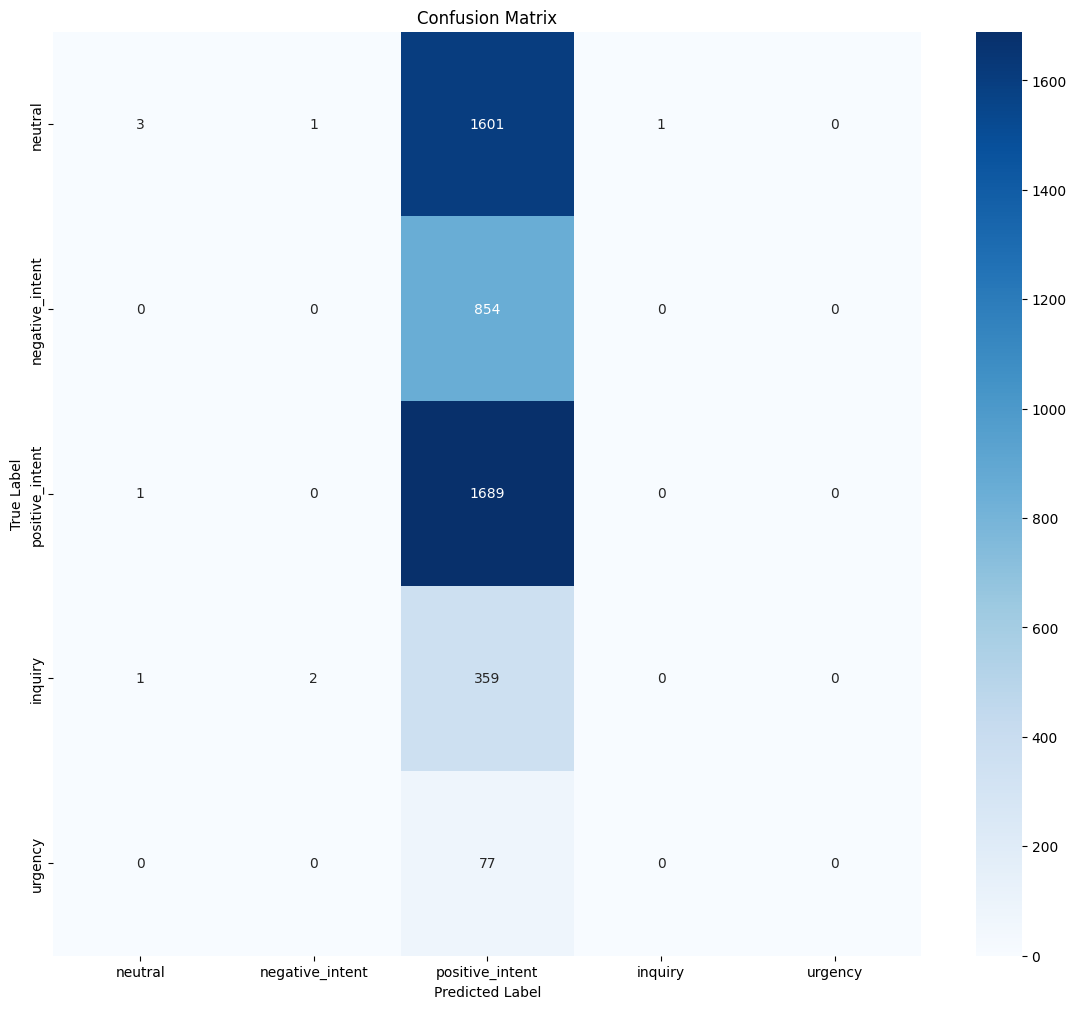

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[category_to_int_mapping[i] for i in range(5)], yticklabels=[category_to_int_mapping[i] for i in range(5)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show();

/opt/homebrew/Caskroom/miniforge/base/envs/testk/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/testk/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/testk/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

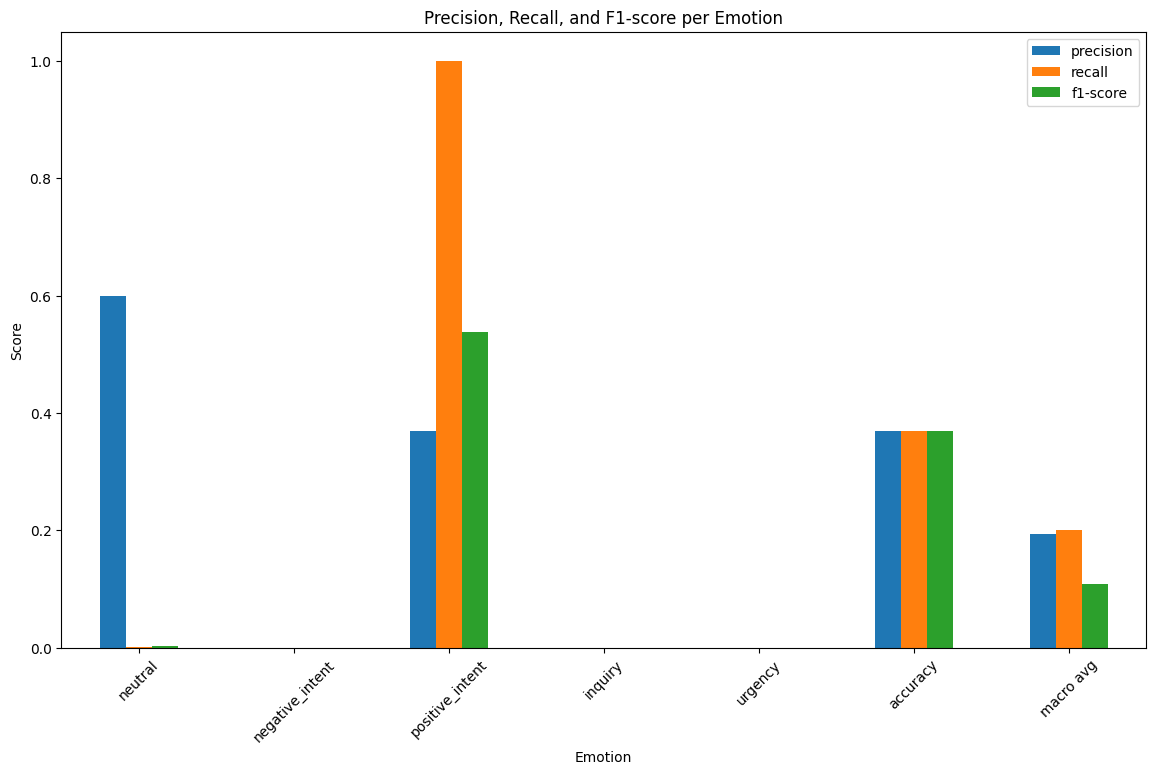

In [7]:
# Evaluate the model
from sklearn.metrics import classification_report

# Evaluate the model
report = classification_report(y_test, predictions, target_names=[category_to_int_mapping[i] for i in range(5)], output_dict=True)

# Extracting precision, recall, and f1-score
metrics = pd.DataFrame(report).transpose().iloc[:-1, :3]  # Excluding 'accuracy' and focusing on precision, recall, f1-score

# Plotting precision, recall, and f1-score
metrics.plot(kind='bar', figsize=(14, 8))
plt.title('Precision, Recall, and F1-score per Emotion')
plt.xlabel('Emotion')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show();

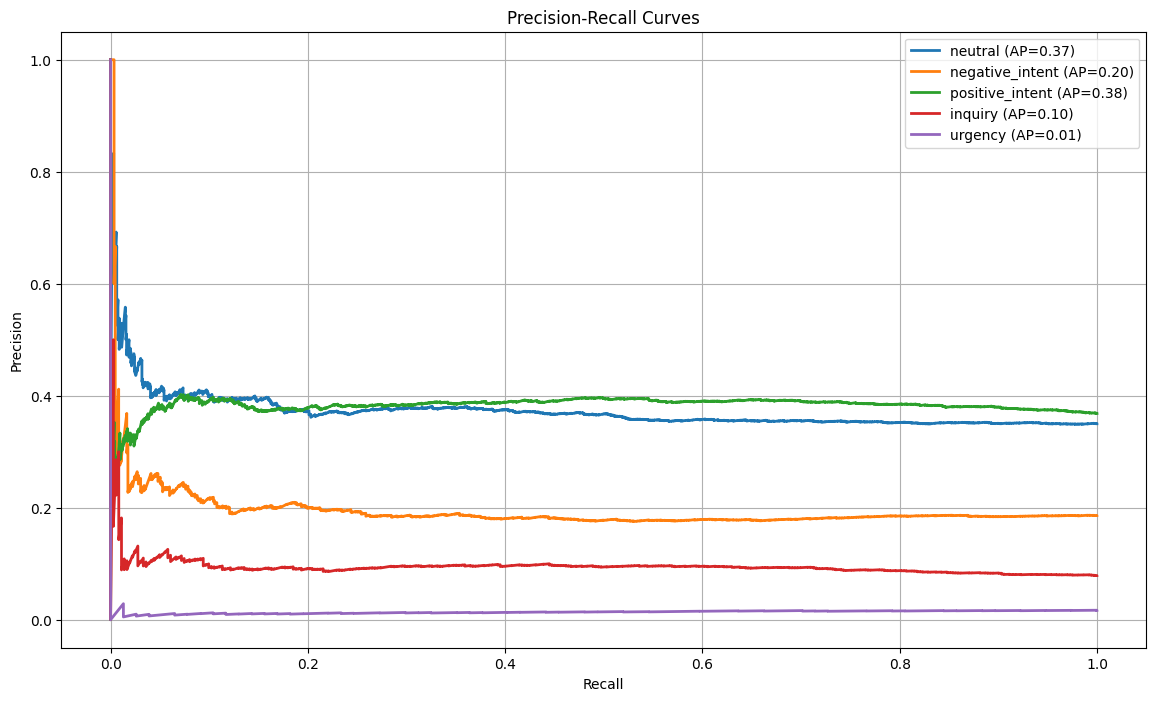

In [8]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Plotting precision-recall curves
plt.figure(figsize=(14, 8))
for i in range(5):
    precision, recall, _ = precision_recall_curve(y_test == i, logits[:, i])
    average_precision = average_precision_score(y_test == i, logits[:, i])
    plt.plot(recall, precision, lw=2, label=f'{category_to_int_mapping[i]} (AP={average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()